In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import datasets
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
data = pd.read_csv("datasets/pmsm_temps.csv")
data.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


In [3]:
data_20 = data[data["profile_id"] == 20]
data_20.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
33423,-1.908649,-1.079592,0.323421,-1.294816,-1.222431,-0.242639,1.029656,-0.245912,-2.484866,-1.811525,-2.055589,-1.997400,20
33424,-1.945673,-1.079477,0.318831,-1.293665,-1.222432,-0.240214,1.029574,-0.245876,-2.484019,-1.811462,-2.055858,-1.996591,20
33425,-1.946597,-1.079168,0.319580,-1.297363,-1.222431,-0.239513,1.029505,-0.245856,-2.484323,-1.811073,-2.056149,-1.995407,20
33426,-1.947213,-1.077655,0.321388,-1.295731,-1.222431,-0.238094,1.033528,-0.247344,-2.484937,-1.811298,-2.056193,-1.995178,20
33427,-1.952527,-1.075799,0.321497,-1.298276,-1.222431,-0.237660,1.032298,-0.246866,-2.485552,-1.810891,-2.056976,-1.994601,20


In [4]:
drop_targets = ["profile_id", "stator_yoke", "stator_winding", "stator_tooth", "torque"]
target = "pm"
data_dropped = data_20.drop(labels = drop_targets,axis=1).reset_index(drop=True)
data_dropped.head()

,ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,pm
0,-1.908649,-1.079592,0.323421,-1.294816,-1.222431,1.029656,-0.245912,-2.484866
1,-1.945673,-1.079477,0.318831,-1.293665,-1.222432,1.029574,-0.245876,-2.484019
2,-1.946597,-1.079168,0.319580,-1.297363,-1.222431,1.029505,-0.245856,-2.484323
3,-1.947213,-1.077655,0.321388,-1.295731,-1.222431,1.033528,-0.247344,-2.484937
4,-1.952527,-1.075799,0.321497,-1.298276,-1.222431,1.032298,-0.246866,-2.485552


In [5]:
corr = data_dropped.corr()
corr = corr ["pm"].abs().sort_values(ascending = False )
corr

pm             1.000000
i_d            0.615226
u_d            0.580232
ambient        0.574095
motor_speed    0.444886
coolant        0.237368
i_q            0.219197
u_q            0.204726
Name: pm, dtype: float64

In [6]:
usefull_columns = corr[:7].index
usefull_columns
data_usefull = data_dropped[usefull_columns]
corr_usefull = data_usefull.corr()
data_usefull.head()

,pm,i_d,u_d,ambient,motor_speed,coolant,i_q
0,-2.484866,1.029656,0.323421,-1.908649,-1.222431,-1.079592,-0.245912
1,-2.484019,1.029574,0.318831,-1.945673,-1.222432,-1.079477,-0.245876
2,-2.484323,1.029505,0.319580,-1.946597,-1.222431,-1.079168,-0.245856
3,-2.484937,1.033528,0.321388,-1.947213,-1.222431,-1.077655,-0.247344
4,-2.485552,1.032298,0.321497,-1.952527,-1.222431,-1.075799,-0.246866


<AxesSubplot:>

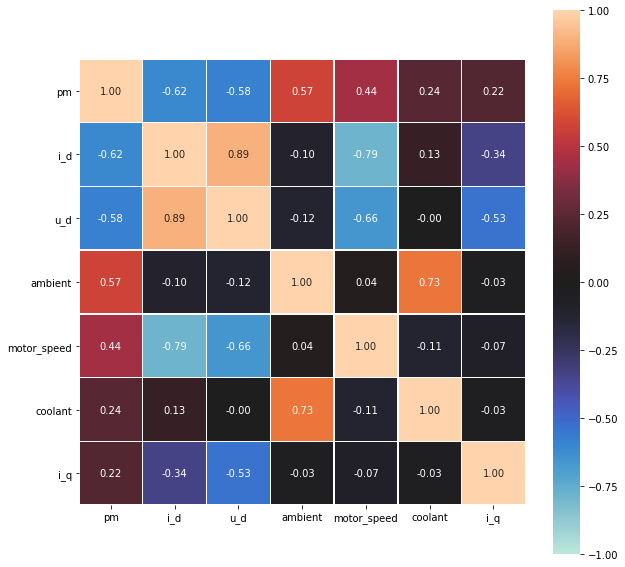

In [10]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=corr_usefull, vmax=1.0, vmin=-1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.858629 to fit


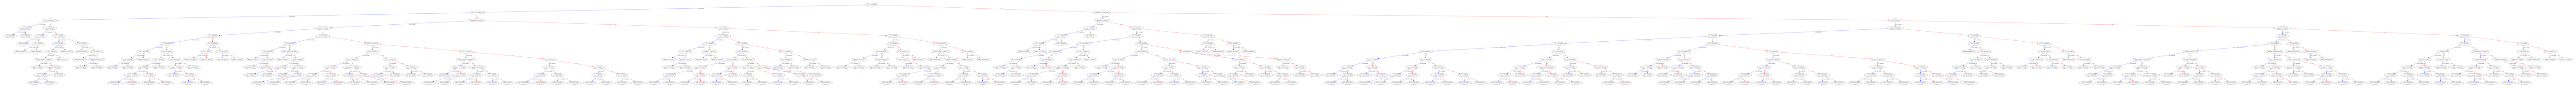

(41771, 6)
(2199, 6)


<Figure size 432x288 with 0 Axes>

In [23]:
import xgboost as xgb
y = data_usefull["pm"]
x = data_usefull.iloc[:, 1:]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.95)
fig, ax = plt.subplots(figsize=(100, 100))
xgb.plot_tree(model, num_trees=4, ax=ax)
plt.show()
plt.savefig("temp.jpg")

print(x_train.shape)
print(x_test.shape)

In [12]:
model = XGBClassifier()
model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 30,max_depth=10,learning_rate=0.2) 
model.fit(x_train, y_train)  
pred = model.predict(x_test)



In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print ("MSE: ", mean_squared_error(y_test, pred))
print ("MAE: ", mean_absolute_error(y_test, pred))
print("STD: ", y_test.std())

MSE:  0.0022647460622010032
MAE:  0.02370054365808176
STD:  1.2275339267617547


In [14]:
results = pd.concat([pd.Series(y_test.values), pd.Series(pred)], axis=1)
results.columns = ["y_true", "preds"]
results_sorted = results.sort_values("y_true")
results_reset = results_sorted.reset_index(drop=True)
results_reset.head()

,y_true,preds
0,-2.484762,-2.480897
1,-2.482669,-2.479211
2,-2.461882,-2.452271
3,-2.456886,-2.452271
4,-2.448567,-2.424279


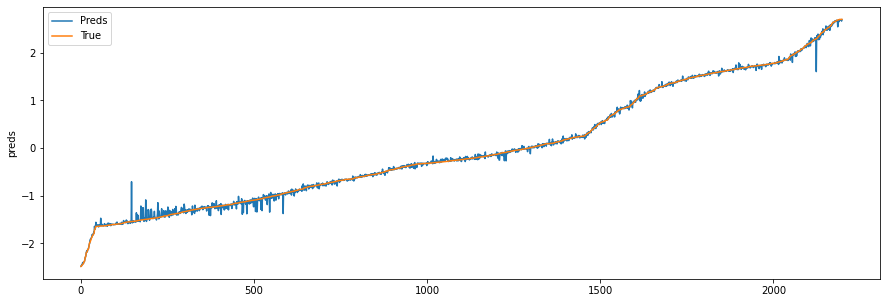

In [15]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=results_reset, y="preds", x=results_reset.index, label="Preds")
sns.lineplot(data=results_reset, y="y_true", x=results_reset.index, label="True")
plt.legend()

<BarContainer object of 6 artists>

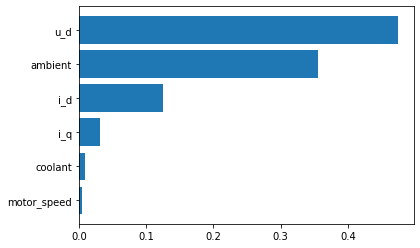

In [16]:
sort_index = model.feature_importances_.argsort()
model.feature_importances_[sort_index]
plt.barh(x_train.columns[sort_index], model.feature_importances_[sort_index])